# Visualizing Models, Data and Training with Tensorboard

In [1]:
# import necessary libraries and modules
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Transformations are preprocessing pipeline that every image passes through before going through training or inference.
The model expects tensors not raw image arrays and normalization helps in gradients flow better. Data augmentations through transformation make model more robust.

In [2]:
# define transformations for the dataset by stacking a chain of preprocessing steps
# each image will go through these steps before being fed to the model
transform = transforms.Compose(
    # Convert PIL Image [0,255] or numpy.ndarray to Pytorch tensor [0,1]
    [transforms.ToTensor(), 
    # Normalize tensor with mean(0.5) and std deviation(0.5) to range [-1,1]
    # Keeps input centered around 0 and helps optimization (gradient descent) converge faster
    # Prevents one feature (pixel brightness) from dominating others
    # works better with activation functions like tanh, sigmoid
    transforms.Normalize((0.5,), (0.5,))]) 

In [3]:
# load datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

In [4]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [5]:
# Convs to extract features (edges, shapes, textures).
# Pooling to reduce spatial size while keeping important info.
# FC layers to make final classification decisions.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input channel 1 (grayscale), output 6 channels enough to capture basic features
        self.conv1 = nn.Conv2d(1, 6, 5) 
        # Half the spatial dimensions keeps strongest features, reduces computation
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Before going into fully connected layers, flatten the 3D tensor to 1D, -1 infers batch size
        x = x.view(-1, 16 * 4 * 4)
        # RELU adds non-linearity, helps model learn complex patterns
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Writing into Tensorboard

In [7]:
from torch.utils.tensorboard import SummaryWriter

# SummaryWriter is our key object for writing information to Tensorboard
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

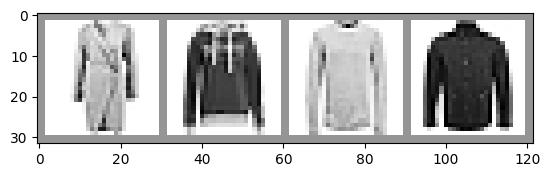

In [8]:
# Makes an iterator object out of the dataloader object
dataiter = iter(trainloader)
# gives the next batch of images and labels (4 each bc batch_size=4)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [9]:
# write model graph to tensorboard
writer.add_graph(net, images)
writer.close()

In [10]:
# The purpose of this code is to select a random subset of images and their corresponding labels from
# the training dataset, reshape the images into flat feature vectors, and then log these embeddings to
# Tensorboard. This allows visualization of how the images are arranged in the high-dimensional feature space.
#
# The function select_n_random randomly picks n datapoints (and their labels) from the dataset.
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset.
    
    The function first creates a random permutation of the indices, then selects the first n datapoints.
    This helps in visualizing a diverse subset of the dataset in Tensorboard.
    '''
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Select a random subset of images and labels from the training dataset
images, labels = select_n_random(trainset.data, trainset.targets)

# Convert label indices to their actual class names using the `classes` tuple.
class_labels = [classes[lab] for lab in labels]

# Reshape the images into feature vectors (flattening each 28x28 image into a 784-dimensional vector)
features = images.view(-1, 28 * 28)

# Log the embeddings to Tensorboard. For each image, we record its flattened feature vector,
# its class (metadata), and the original image (as label_img) for context.
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.close()

The function images_to_probs computes the network’s predictions on a batch of images and returns both the predicted class indices and their corresponding probabilities (using softmax on the logits). The function plot_classes_preds uses images_to_probs to obtain predictions and probabilities, then shows a grid of images with the predicted and true labels annotated, coloring predictions in green if they match and in red if they don’t.

In [11]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [12]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [13]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)